## NLP: Real or Not? NLP with Disaster Tweets

### 1. Cargar las librerías y el dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train_df = pd.read_csv('data/train.csv', index_col='id')
x_test = pd.read_csv('data/test.csv', index_col='id')

### 2. Datos Estadísticos

#### 2.1. Datos Nulos

Obtenemos el total y el porcentaje de datos nulos ordenados de mayor a menor.

In [3]:
# Total de datos nulos
total = train_df.isna().sum().sort_values(ascending=False)

# Porcentaje de datos nulos
porcentaje = (total / train_df.shape[0]).sort_values(ascending=False)

datos_nulos = pd.concat([total, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
datos_nulos.head(train_df.shape[1])

,Total,Porcentaje
location,2533,0.332720
keyword,61,0.008013
target,0,0.000000
text,0,0.000000


#### 2.2. ¿Qué hacemos con los datos nulos?

Uno de los mayores problemas en Machine Learning es lidiar con los datos nulos. Se anexa la siguiente captura de pantalla, que hace referencia al tratamiento de estos datos nulos:

<img alt="Esquema gestión datos nulos" src='https://miro.medium.com/max/1528/1*_RA3mCS30Pr0vUxbp25Yxw.png' width="550px" style='float:left;'>
<div style='clear:both'></div>

La columna `location` contiene muchos elementos nulos (> 30 %). Por tanto, la eliminamos.

In [4]:
# Eliminamos la columna 'location' de train y test
train_df.drop(['location'], axis=1, inplace=True)
x_test.drop(['location'], axis=1, inplace=True)

In [5]:
# Mostramos las primeras filas de train
train_df.head()

,keyword,text,target
id,,,
1,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### 2.3. Distribución de los datos

In [6]:
print("Distribución de tweets (desastres y no desastres)", end="\n\n")
train_df.target.value_counts()

Distribución de tweets (desastres y no desastres)



0    4342
1    3271
Name: target, dtype: int64

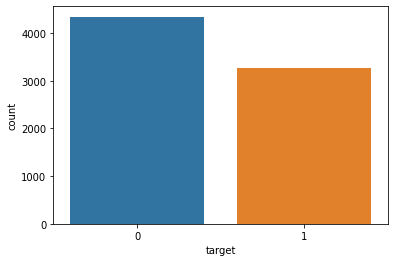

In [7]:
sns.countplot(data=train_df, x='target');

#### 2.4. Información de los datos

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7552 non-null   object
 1   text     7613 non-null   object
 2   target   7613 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 557.9+ KB


### 3. Separamos las columnas del target

In [9]:
X = train_df.drop(['target'], axis=1)
y = train_df.target

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42)

### 4. Rellenar keywords nulas

In [11]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

imputed_train = pd.DataFrame(imputer.fit_transform(x_train))
imputed_valid = pd.DataFrame(imputer.transform(x_valid))
imputed_test = pd.DataFrame(imputer.transform(x_test))

# Imputation removed column names; put them back
imputed_train.columns = x_train.columns
imputed_valid.columns = x_valid.columns
imputed_test.columns = x_test.columns

In [12]:
print("Número de elementos nulos:", end="\n\n")
print(imputed_train.isna().sum(), end="\n\n")
print(imputed_valid.isna().sum(), end="\n\n")
print(imputed_test.isna().sum())

Número de elementos nulos:

keyword    0
text       0
dtype: int64

keyword    0
text       0
dtype: int64

keyword    0
text       0
dtype: int64


### 5. NLP Preprocessing

In [13]:
import nltk, string, re
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [14]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

#### 5.1. Convertir todo el texto a minúsculas

In [15]:
def lower(text):
  return text.lower()

#### 5.2. Tokenización de Palabras

In [16]:
def tokenisation(text):
  return nltk.word_tokenize(text)

#### 5.3. Eliminar Stop Words y texto no alfabético

In [17]:
# Create a list of stopwords
stpwrd_list = stopwords.words('english')

In [18]:
def StopWordsAlphaText(tokenized_text):
  filtred_text = []

  for word in tokenized_text:
    # strip punctuation
    word = word.strip('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    # check if the word starts with an alphabet
    val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", word)
    # ignore if it is a stop word or val is none
    if ((word not in stpwrd_list) and (val is not None)):
      filtred_text.append(word)
  
  return filtred_text

#### 5.4. Extraer el lema de las palabras

In [19]:
from nltk.corpus import wordnet

tag_dict = {"J": wordnet.ADJ,
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}

In [20]:
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  return tag_dict.get(tag, wordnet.NOUN)

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
def Lemmetizer(tokens):
  lemmetized_text = []

  for word in tokens:
    word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
    lemmetized_text.append(word)
  
  return lemmetized_text

#### 5.5. Limpiamos el texto

In [23]:
def clean_text(dataframe):
  dataframe.text = dataframe.text.apply(lower)
  dataframe.text = dataframe.text.apply(lambda x: re.sub(r"https?://\S+|www\.\S+", "", x))
  dataframe.text = dataframe.text.apply(lambda x: re.sub('amp', '', x))
  dataframe.text = dataframe.text.apply(lambda x: re.sub('via', '', x))
  dataframe.text = dataframe.text.apply(tokenisation)
  dataframe.text = dataframe.text.apply(StopWordsAlphaText)
  dataframe.text = dataframe.text.apply(Lemmetizer)

In [24]:
clean_text(imputed_train)
clean_text(imputed_valid)
clean_text(imputed_test)
clean_text(train_df)

### 6. Nube de palabras

#### 6.1. Nube de palabras a partir de la columna texto

In [25]:
y_train.reset_index(drop=True, inplace=True)

dataFr = pd.DataFrame({'keyword': imputed_train.keyword,
                       'text': imputed_train.text,
                       'target': y_train})

In [26]:
real = ""
fake = ""

for index, row in dataFr.iterrows():
  text = " ".join(row["text"])

  if (row["target"] == 1):
    real += " " + text
  else:
    fake += " " + text

In [27]:
# Create a real_tweets wordcloud
wordcloud_real = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(real)
# Create a fake_tweets wordcloud
wordcloud_fake = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(fake)

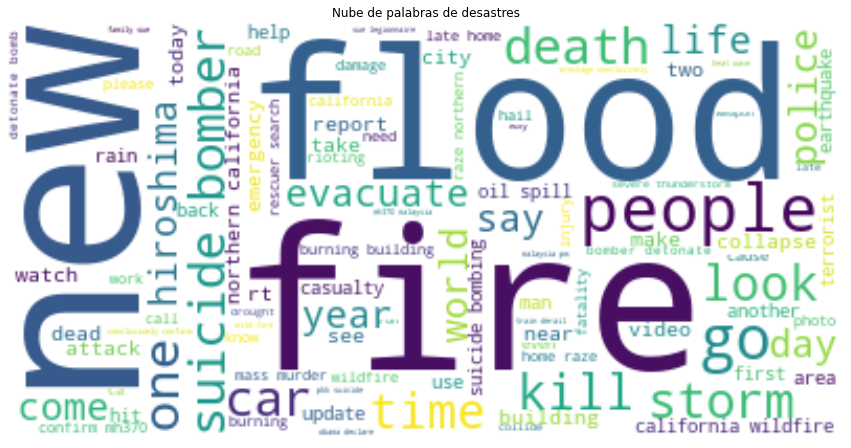

In [28]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de desastres")
plt.show()

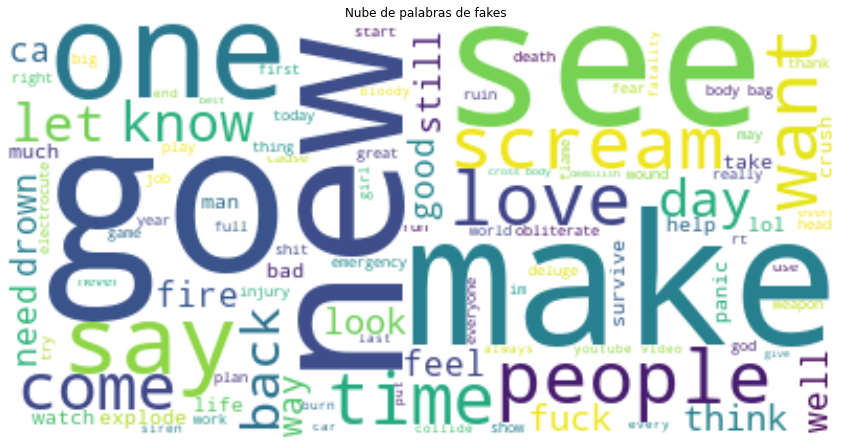

In [29]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de fakes")
plt.show()

#### 6.2. Nube de palabras a partir de la columna keyword

In [30]:
real = ""
fake = ""

for word in dataFr.loc[dataFr['target'] == 1, 'keyword']:
  word = re.sub('%20', ' ', word)
  real = real + " " + word

for word in dataFr.loc[dataFr['target'] == 0, 'keyword']:
  word = re.sub('%20', ' ', word)
  fake = fake + " " + word

In [31]:
# Create a real_tweets wordcloud
wordcloud_real = WordCloud(collocations=False, max_font_size=100, max_words=100, background_color="white").generate(real)
# Create a fake_tweets wordcloud
wordcloud_fake = WordCloud(collocations=False, max_font_size=100, max_words=100, background_color="white").generate(fake)

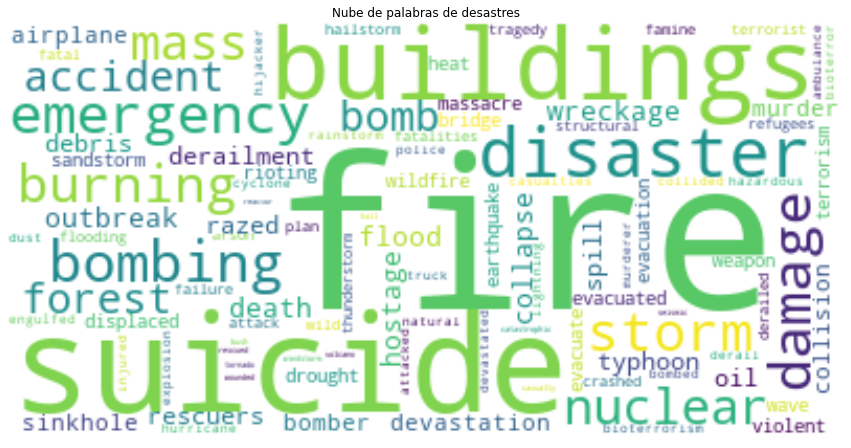

In [32]:
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de desastres")
plt.show()

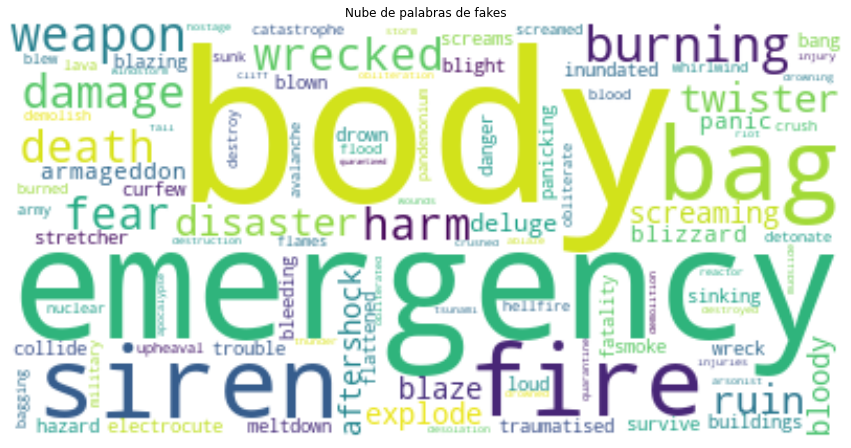

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de fakes")
plt.show()

### 7. Preprocesamiento de los datos

#### 7.1. Limpiar los datasets

En primer lugar, tenemos que convertir la columna 'text' de los dataframes de un array de palabras a un string con todas las palabras separadas por espacios en blanco.

In [34]:
imputed_train.text = imputed_train.text.apply(lambda x: " ".join(x))
imputed_valid.text = imputed_valid.text.apply(lambda x: " ".join(x))
imputed_test.text = imputed_test.text.apply(lambda x: " ".join(x))

A continuación, sustituimos los símbolos '%20' por ' ' en la columna keyword de los distintos dataframes.

In [35]:
imputed_train.keyword = imputed_train.keyword.apply(lambda x:re.sub('%20', ' ', x))
imputed_valid.keyword = imputed_valid.keyword.apply(lambda x:re.sub('%20', ' ', x))
imputed_test.keyword = imputed_test.keyword.apply(lambda x:re.sub('%20', ' ', x))

#### 7.2. CountVectorizer

Vamos a probar CountVectorizer() para obtener nuestra matrix de términos de documentos.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 2))
matrix = count_vect.fit_transform(imputed_train.text)

# Tamaño de la matriz
print("Shape:", matrix.shape, end="\n\n")

# Forma de la matriz
print("Matrix:")
matrix.toarray()

Shape: (6090, 47119)

Matrix:


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
count_vect2 = CountVectorizer(analyzer='word', ngram_range=(1, 2))
matrix2 = count_vect2.fit_transform(imputed_train.text)

# Tamaño de la matriz
print(matrix2.shape, end="\n\n")

# Forma de la matriz
matrix2.toarray()

(6090, 47119)



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### 7.3. Term Frequency - Inverse Document Frequency (TF-IDF)

Esto reduce el peso de las palabras más comunes como (the, is, an, etc.) que aparecen en todos los documentos.

TF-IDF es una estadística numérica que pretende reflejar la importancia que tiene una palabra para un documento en una colección o corpus.

##### 7.3.1. TfidfTransformer

Esta función se aplica sobre la matriz obtenida por CountVectorizer.

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_trans = TfidfTransformer()
matx = tfidf_trans.fit_transform(matrix2)

# Tamaño de la matriz
print(matx.shape, end="\n\n")

# Forma de la matriz
matx.toarray()

(6090, 47119)



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##### 7.3.2. TfidfVectorizer

Las dos funciones anteriores se combinan en otra llamada 'TfidfVectorizer'

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
mat = tfidf_vect.fit_transform(imputed_train.text)

# Tamaño de la matriz
print("Shape:", mat.shape, end="\n\n")

# Forma de la matriz
print("Matrix:")
mat.toarray()

Shape: (6090, 11726)

Matrix:


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### 7.4. Pipeline

In [40]:
from sklearn.pipeline import Pipeline

text_transformer = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('TfidfTransformer', TfidfTransformer())
])

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

preprocessing = ColumnTransformer([
    ('Text Features', text_transformer, 'text'),
    ('Categorical Features', OrdinalEncoder(), ['keyword'])
])

In [42]:
X_train = preprocessing.fit_transform(imputed_train)
X_valid = preprocessing.transform(imputed_valid)
X_test = preprocessing.transform(imputed_test)

### 8. Modelos e Hiperparámetros

#### 8.1. Modelos Clasificadores

En esta sección vamos a comparar la precisión de distintos modelos de clasificación.

In [43]:
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score


names = ["Gaussian Naive Bayes", "Multinomial Naive Bayes", "Bernoulli Naive Bayes",
         "Ridge Classifier", "Logistic Regression", "Decision Tree Classifier",
         "Random Forest Classifier"]

classifiers = [GaussianNB(), MultinomialNB(), BernoulliNB(), RidgeClassifier(),
               LogisticRegression(max_iter=200), DecisionTreeClassifier(),
               RandomForestClassifier()]

#### Matrices de confusión

In [44]:
from sklearn.metrics import confusion_matrix

for name, clf in zip(names, classifiers):
  preds = cross_val_predict(clf, X_train.toarray(), y_train, cv=3)
  print(name, "Confusion Matrix:")
  print(confusion_matrix(y_train, preds), end="\n\n")

Gaussian Naive Bayes Confusion Matrix:
[[1771 1697]
 [ 606 2016]]

Multinomial Naive Bayes Confusion Matrix:
[[3327  141]
 [1504 1118]]

Bernoulli Naive Bayes Confusion Matrix:
[[3152  316]
 [ 905 1717]]

Ridge Classifier Confusion Matrix:
[[3056  412]
 [ 859 1763]]

Logistic Regression Confusion Matrix:
[[3197  271]
 [ 980 1642]]

Decision Tree Classifier Confusion Matrix:
[[2767  701]
 [ 849 1773]]

Random Forest Classifier Confusion Matrix:
[[3154  314]
 [1021 1601]]



In [45]:
from time import time

for name, clf in zip(names, classifiers):
  # Cross validation prediction, and we measure fitting time
  start = time()
  preds = cross_val_predict(clf, X_train.toarray(), y_train, cv=3)
  end = time()

  # Metrics
  acc = accuracy_score(y_train, preds)
  precision = precision_score(y_train, preds)
  recall = recall_score(y_train, preds)
  f1 = f1_score(y_train, preds)

  # Printing results
  print(name,
        'Accuracy:', "%.2f" %(acc * 100), '%',
        ', Precision:', "%.3f" %precision,
        ', Recall:', "%.3f" %recall, ', F1-Score:', "%.3f" %f1)
  
  # We check how long did it take
  print('Time used:', "%.3f" %(end - start), 'seconds')
  print('*-----------------------------------------------------------------------------------------------------*')

Gaussian Naive Bayes Accuracy: 62.18 % , Precision: 0.543 , Recall: 0.769 , F1-Score: 0.636
Time used: 3.799 seconds
*-----------------------------------------------------------------------------------------------------*
Multinomial Naive Bayes Accuracy: 72.99 % , Precision: 0.888 , Recall: 0.426 , F1-Score: 0.576
Time used: 1.192 seconds
*-----------------------------------------------------------------------------------------------------*
Bernoulli Naive Bayes Accuracy: 79.95 % , Precision: 0.845 , Recall: 0.655 , F1-Score: 0.738
Time used: 2.274 seconds
*-----------------------------------------------------------------------------------------------------*
Ridge Classifier Accuracy: 79.13 % , Precision: 0.811 , Recall: 0.672 , F1-Score: 0.735
Time used: 13.604 seconds
*-----------------------------------------------------------------------------------------------------*
Logistic Regression Accuracy: 79.46 % , Precision: 0.858 , Recall: 0.626 , F1-Score: 0.724
Time used: 13.267 second

#### 8.2. Hiperparámetros

De los modelos de clasificación probados en la sección anterior, el que mejor resultados nos ha dado ha sido el modelo **Bernoulli Naive Bayes**. En esta sección emplearemos un `GridSearch` para encontrar los parámetros óptimos (hiperparámetros).

In [46]:
# Parámetros para Bernoulli Naive Bayes

from sklearn.model_selection import GridSearchCV

param = [
         {'alpha': np.arange(0.01, 1.00, 0.01),
          'fit_prior': [True, False]
         }
]

model = BernoulliNB()

In [47]:
GridSearch = GridSearchCV(estimator=model, param_grid=param, cv=5,
                          scoring='f1', return_train_score=True)

In [48]:
GridSearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37...
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                          'fit_prior': [True, False]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
     

In [49]:
results = GridSearch.cv_results_

for mean_score, params in zip(results["mean_test_score"], results["params"]):
  print("F1 Score: %.3f" %mean_score, ' | Parameters:', params)

F1 Score: 0.731  | Parameters: {'alpha': 0.01, 'fit_prior': True}
F1 Score: 0.732  | Parameters: {'alpha': 0.01, 'fit_prior': False}
F1 Score: 0.734  | Parameters: {'alpha': 0.02, 'fit_prior': True}
F1 Score: 0.734  | Parameters: {'alpha': 0.02, 'fit_prior': False}
F1 Score: 0.736  | Parameters: {'alpha': 0.03, 'fit_prior': True}
F1 Score: 0.735  | Parameters: {'alpha': 0.03, 'fit_prior': False}
F1 Score: 0.738  | Parameters: {'alpha': 0.04, 'fit_prior': True}
F1 Score: 0.737  | Parameters: {'alpha': 0.04, 'fit_prior': False}
F1 Score: 0.739  | Parameters: {'alpha': 0.05, 'fit_prior': True}
F1 Score: 0.740  | Parameters: {'alpha': 0.05, 'fit_prior': False}
F1 Score: 0.742  | Parameters: {'alpha': 0.060000000000000005, 'fit_prior': True}
F1 Score: 0.742  | Parameters: {'alpha': 0.060000000000000005, 'fit_prior': False}
F1 Score: 0.743  | Parameters: {'alpha': 0.06999999999999999, 'fit_prior': True}
F1 Score: 0.742  | Parameters: {'alpha': 0.06999999999999999, 'fit_prior': False}
F1 Scor

In [73]:
GridSearch.best_estimator_

BernoulliNB(alpha=0.5700000000000001, binarize=0.0, class_prior=None,
            fit_prior=False)

In [69]:
final_model = GridSearch.best_estimator_

#### 8.3. Pipeline definitivo

Una vez que tenemos los parámetros optimos para nuestro modelo, creamos nuestro pipeline definitivo.

In [52]:
final_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('clf', final_model)
])

##### 8.3.1. Entrenamos el pipeline con los datos de entrenamiento

In [53]:
final_pipeline.fit(imputed_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessing',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('Text Features',
                                                  Pipeline(memory=None,
                                                           steps=[('CountVectorizer',
                                                                   CountVectorizer(analyzer='word',
                                                                                   binary=False,
                                                                                   decode_error='strict',
                                                                                   dtype=<class 'numpy.int64'>,
                                                                                   encoding='utf-8',
                   

##### 8.3.2. Realizamos predicciones sobre los datos de validación

In [54]:
preds = final_pipeline.predict(imputed_valid)

In [81]:
final_pipeline.named_steps

{'clf': BernoulliNB(alpha=0.5700000000000001, binarize=0.0, class_prior=None,
             fit_prior=False),
 'preprocessing': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('Text Features',
                                  Pipeline(memory=None,
                                           steps=[('CountVectorizer',
                                                   CountVectorizer(analyzer='word',
                                                                   binary=False,
                                                                   decode_error='strict',
                                                                   dtype=<class 'numpy.int64'>,
                                                                   encoding='utf-8',
                                                                   input='content',
                                                            

##### 8.3.3. Métricas (confusion matrix, accuracy, precision, recall, f1)

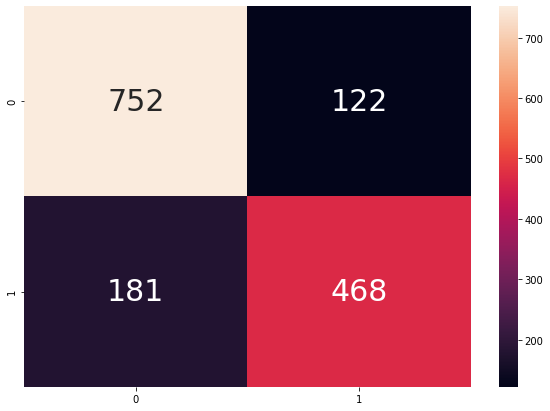

In [55]:
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_valid, preds), annot=True, annot_kws={"size": 30}, fmt='d')
plt.show()

In [56]:
print('Final model:\n')
print('Accuracy:', '%.2f' %(accuracy_score(y_valid, preds) * 100), '%')
print('Precision:', '%.3f' %precision_score(y_valid, preds))
print('Recall:', '%.3f' %recall_score(y_valid, preds))
print('F1 Score:', '%.3f' %f1_score(y_valid, preds))

Final model:

Accuracy: 80.11 %
Precision: 0.793
Recall: 0.721
F1 Score: 0.755


##### 8.3.4. Métricas (ROC y AUC)

In [57]:
from sklearn.metrics import roc_auc_score

print("ROC AUC Score:", roc_auc_score(y_valid, preds))

ROC AUC Score: 0.790760649194501


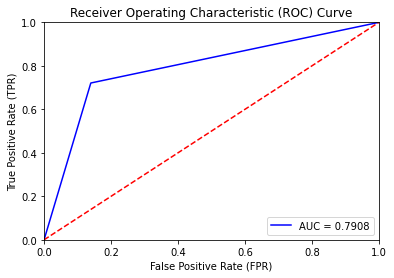

In [58]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_valid, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show()

### 9. Competición

In [59]:
predicciones = final_pipeline.predict(imputed_test)

# Creamos un dataframe con nuestras predicciones
output = pd.DataFrame({'id': x_test.index,
                       'target': predicciones})

# Guardamos nuestras predicciones en submission.csv
output.to_csv('submission.csv', index=False)